# Dataset

**Upload Dataset**

In [1]:
!mkdir data
%cd data
!mkdir train validation
%cd train
!mkdir polyps non_polyps
% cd ../validation
!mkdir polyps non_polyps
%cd /content

/content/data
/content/data/train
/content/data/validation
/content


Upload compressed data folder and extract that into *data* directory

In [0]:
!unzip -qq data.zip -d /content/synthetic/

In [0]:
%cd /content
!unzip -qq Archive.zip -d /content/Colonoscopy-polyps-detection-with-CNNs/synthetic/

/content


In [0]:
%cd /content/Colonoscopy-polyps-detection-with-CNNs/

/content/Colonoscopy-polyps-detection-with-CNNs


**Split polyps / non-polyps dataset**

Use polyps and non_polyps from data/ to copy files into train and validation. We shall use a dataset split percentage such as 75% train and 25% test.

We need os and shutil to manage the files, random to randomly split the dataset in train and validation subsets.

In [0]:
import os
import random
import shutil

In [0]:
# Source dataset: from where to copy the files
sourceFolderClass1 = 'data/polyps'
sourceFolderClass2 = 'data/non_polyps'
# Destination folders: splitted dataset in train and validation for polyps and non-polyps
destFolderClass1_tr  = 'data/train/polyps'
destFolderClass2_tr  = 'data/train/non_polyps'
destFolderClass1_val = 'data/validation/polyps'
destFolderClass2_val = 'data/validation/non_polyps'

In [0]:
sourceFiles1 = os.listdir(sourceFolderClass1)
sourceFiles2 = os.listdir(sourceFolderClass2)
print("Class 1 - polyps:", len(sourceFiles1))
print("Class 2 - non-polyps:", len(sourceFiles2))

Class 1 - polyps: 1449
Class 2 - non-polyps: 1690


In [0]:
number_files = (min(len(sourceFiles1), len(sourceFiles2)) // 64) * 64
for file in sourceFiles1[number_files:]:
  os.remove(sourceFolderClass1+'/'+file)
  
for file in sourceFiles2[number_files:]:
  os.remove(sourceFolderClass2+'/'+file)
  
sourceFiles1 = os.listdir(sourceFolderClass1)
sourceFiles2 = os.listdir(sourceFolderClass2)
  
print("Class 1 - polyps:", len(sourceFiles1))
print("Class 2 - non-polyps:", len(sourceFiles2))

Class 1 - polyps: 1408
Class 2 - non-polyps: 1408


Let's suffle the list with the source files using a random seed:

In [0]:
random.seed(1)
random.shuffle(sourceFiles1)
random.shuffle(sourceFiles2)

We shall define a number of files to copy in the `validation` subfolder for each class. If you want a different split, you should modify `val_files`.

In [0]:
# No of file to copy in VALIDATION folder for each class
val_files = 128

# Copy the first 151 files for polyps and non-polyps into validation folders
print('--> Validation split ...')
for i in range(val_files):
    # copy validation polyps
    File1 = os.path.join(sourceFolderClass1,sourceFiles1[i])
    File2 = os.path.join(destFolderClass1_val,  sourceFiles1[i])
    shutil.copy(File1,File2)
    # copy validation non-polyps
    File1 = os.path.join(sourceFolderClass2, sourceFiles2[i])
    File2 = os.path.join(destFolderClass2_val,   sourceFiles2[i])
    shutil.copy(File1, File2)

print('--> Done!')

--> Validation split ...
--> Done!


In [0]:
# Copy polyps to train
print('--> Train split ...')
for i in range(val_files,len(sourceFiles1)):
    if sourceFiles1[i].startswith('.'):
      continue
    File1 = os.path.join(sourceFolderClass1,  sourceFiles1[i])
    File2 = os.path.join(destFolderClass1_tr, sourceFiles1[i])
    shutil.copy(File1,File2)
# copy non-polyps to train
for i in range(val_files,len(sourceFiles2)):
    if sourceFiles2[i].startswith('.'):
      continue
    File1 = os.path.join(sourceFolderClass2,  sourceFiles2[i])
    File2 = os.path.join(destFolderClass2_tr, sourceFiles2[i])
    shutil.copy(File1, File2)

print('--> Done!')

--> Train split ...
--> Done!


Now we have a splitted dataset into train and validation subfolder with each class inside:
* **1212** images in the entire dataset;
* **910** images for training: 455 polyps + 455 non-polyps;
* **302** images for validation: 151 polyps + 151 non-polyps.

Let's check the composition of the subsets for the future classification:

In [0]:
print('--> Dataset: data_polyps')
print('> Train - polyps:', len(os.listdir(destFolderClass1_tr)))
print('> Train - non-polyps:', len(os.listdir(destFolderClass2_tr)))
print('> Validation - polyps:', len(os.listdir(destFolderClass1_val)))
print('> Validation - non-polyps:', len(os.listdir(destFolderClass2_val)))

--> Dataset: data_polyps
> Train - polyps: 1280
> Train - non-polyps: 1280
> Validation - polyps: 128
> Validation - non-polyps: 128


# Training

In [0]:
import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import roc_auc_score
from numpy.random import seed
from tensorflow import set_random_seed

import time, os
from __future__ import with_statement

%matplotlib inline

This is a function that will help you to visualize the training and validation accuracy during the training inside the browser (source: live_loss_plot_keras.ipynb).

Note: if you want to run the training script not inside the notebook, you need to remove this function call from your traning! If not, after each epoch you will need to manually close the new plot!

In [0]:
class PlotLosses(keras.callbacks.Callback):
    # Show the live training and validation loss during the training
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.acc, label="ACC_Train")
        plt.plot(self.x, self.val_acc, label="ACC_Val")
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                   ncol=2, mode="expand", borderaxespad=0.)
        plt.grid()
        # plt.ylim(0.0, 1.0) # limited Y values to 1.0!
        plt.show()

plot_losses = PlotLosses() # initialize the class

Define several constants:

dimensions for our images to be used in the models

folders for train and validation subsets

number of train and validation samples

In [0]:
# Dimensions of our images.
img_width, img_height = 256, 256

# Train & validation folders
train_data_dir      = 'data/train'
validation_data_dir = 'data/validation'

# Folder to save the models
modelFolder = '/content'

# Train parameters
nb_train_samples      = 2560
nb_validation_samples = 256

Change the order of the dimensions and channel depending on the input image: (channels, width, height) or (width, height, channels). We are using 3 channels for this study (RGB).

In [0]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [0]:
def CNN_3Conv_1FCv2(convs, dims, epochs, batch_size, drop_rate, input_shape):
    # CNN with 3 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # drop_rate = drop rate (0, 1.0) <---- added
    # input_shape = shape of the inputs
    
    # for reproductibility
    seed(1)            # numpy seed
    set_random_seed(2) # tensorflow seed
    
    # Start the computational graph for our CNN
    model = Sequential()
    
    # Conv 1 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 2 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 3 filters
    model.add(Conv2D(convs*2, (dims, dims))) # second Conv has 2x filters!
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs*2)) # FC has 2x neurons!
    model.add(Activation('relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90)

    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[plot_losses], # using the plotting function for train and validation loss
        verbose=0)

    # Evaluate final test loss and accuracy scores
    score_val = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    score_tr  = model.evaluate_generator(train_generator, nb_train_samples//batch_size, workers=7)
    print('Train loss    :', score_tr[0])
    print('Train accuracy:', score_tr[1])
    print('Validation loss    :', score_val[0])
    print('Validation accuracy:', score_val[1])
    
    return model # return the model!

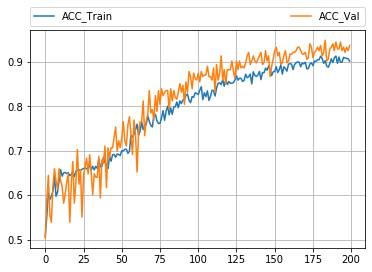

Train loss    : 0.15105308759957553
Train accuracy: 0.9421875
Validation loss    : 0.18210723996162415
Validation accuracy: 0.9375
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 254, 254, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        

In [0]:
print('--> Training best model for Small CNNs: Conv-Conv-Conv-FC ...')
model = CNN_3Conv_1FCv2(convs=64, dims=3, epochs=200, batch_size=64,
                        drop_rate=0.9, input_shape= input_shape)
print(model.summary())

# # Save the weights and the full model
print('---> Save model ...')
model.save_weights('/content/model_combined_asu.h5')
model.save('/content/model_combined_asu.h5')
print('Done!')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd /content

/content


In [0]:
!rm -rf .DS_Store